# BESNet

In [50]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import multiprocessing as mp
from datetime import datetime
import sys
import gc
sys.path.append('../../')
sys.path.insert(0, '../../data/siim-pneumothorax')

from mask_functions import *
from sklearn.model_selection import KFold
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

from dependencies import *
from settings import *
from reproducibility import *
from models.TGS_salt.BesNet import BesNet as Net

In [22]:
SIZE = 256
FACTOR = SIZE
ne = "ne"
initial_checkpoint = None
MODEL = "ResNet34"

batch_size = 8
n_acc = 256 / batch_size
nfolds = 4

noise_th = 75.0*(SIZE/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

data_root = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:0')

In [23]:
def time_to_str(time, str):
    #if str == 'min':
    #	    return str(round(float(time)/60,5))+" min(s)"
    return round(time,4)

In [24]:
#TODO: Instead of directly printing to stdout, copy it into a txt file
class Logger():
    def __init__(self,name=MODEL+ne):
        super().__init__()
        self.model=name
        #if OHEM != "OHEM":
        #    self.model=MODEL+ne[ne.find("_")+1:]
        self.file = open(self.model+"_bes_log.txt","w+")
        self.file.close()
        
        self.debug_file = open(self.model + '_bes_debug.txt', 'w+')
        self.debug_file.close()
    def write(self, str):
        print(str)
        self.file = open(self.model+"_bes_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def write2(self, str):
        print(str, end='',flush=True)
        self.file = open(self.model+"_bes_log.txt","a+")
        self.file.write(str)
        self.file.close()
    def debug(self, str):
        self.debug_file = open(self.model + '_bes_debug.txt', 'a+')
        self.debug_file.write(str)
        self.debug_file.close()
    def stop():
        self.file.close()
        self.debug_file.close()
        
log = Logger()

In [25]:
def valid_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

def train_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())

    if np.random.rand() < 0.5:
         image, mask = do_horizontal_flip2(image, mask)
         pass

    if np.random.rand() < 0.2:
        c = np.random.choice(4)
        if c==0:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.1) #0.125

        if c==1:
            image, mask = do_horizontal_shear2( image, mask, dx=np.random.uniform(-0.02,0.02) )
            pass

        if c==2:
            image, mask = do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=np.random.uniform(0,15))  #10

        if c==3:
            image, mask = do_elastic_transform2(image, mask, grid=10, distort=np.random.uniform(0,0.05))#0.10
            pass
    if np.random.rand() < 0.1:
        c = np.random.choice(3)
        if c==0:
            image = do_brightness_shift(image,np.random.uniform(-0.1,+0.1))
        if c==1:
            image = do_brightness_multiply(image,np.random.uniform(1-0.08,1+0.08))
        if c==2:
            image = do_gamma(image,np.random.uniform(1-0.08,1+0.08))
        # if c==1:
        #     image = do_invert_intensity(image)

    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

In [37]:
def null_augment(image, mask, index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    return image, mask, index, cache

def null_collate(batch):

    batch_size = len(batch)
    cache = []
    input = []
    truth = []
    index = []
    for b in range(batch_size):
        input.append(batch[b][0])
        truth.append(batch[b][1])
        index.append(batch[b][2])
        cache.append(batch[b][3])
    input = torch.from_numpy(np.array(input)).float().unsqueeze(1)

    if truth[0]!=[]:
        truth = torch.from_numpy(np.array(truth)).float().unsqueeze(1)

    return input, truth, index, cache

def get_weights_for_balanced_classes(cls_list, num_classes):
    # get count per class
    count = [0] * num_classes
    
    for cls in cls_list:
        count[cls] += 1

    # get weight per class
    weight_per_class = [0.] * num_classes
    N = float(len(cls_list))
    
    for i in range(num_classes):
        weight_per_class[i] = N / float(count[i])
        
    #　get weight per sample
    weights = [0] * len(cls_list)
    
    for i, cls in enumerate(cls_list):
        weights[i] = weight_per_class[cls]
        
    return weights

def get_boundary(masks):
    mask_arr = (masks.cpu().numpy() * 255).astype(np.uint8).squeeze()
    b_arr = []
    
    for mask in mask_arr:
        b_img = np.zeros(mask.shape)
        
        contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(b_img, contours, -1, 255, 1)
        
        b_arr.append(b_img)
        
    b_arr = np.stack(b_arr)
    
    return torch.from_numpy(b_arr)

class SIIMDataset(Dataset):
    def __init__(self, data_root, fold, pos_neg_ratio=0.5, width=1024, height=1024, phase='train', augment=null_augment, random_state=2019, nfolds=4):
        self.data_root = data_root
        self.fold = fold
        self.height = width
        self.width = height
        self.phase = phase
        self.augment = augment
        
        kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
        train_list = os.listdir(os.path.join(data_root, 'train_png'))
        
        if phase == 'train':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][0]
            self.filenames = [train_list[i] for i in index_list]
            
            # read masks for pos/neg ratio sampler
            train_df = pd.read_csv(os.path.join(self.data_root, 'train-rle.csv'))
            pos_ids = list(train_df[train_df[' EncodedPixels']!=' -1']['ImageId'])

            self.cls_list = [1 if filename.split('.png')[0] in pos_ids else 0 for filename in self.filenames]

        elif phase == 'val':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][1]
            self.filenames = [train_list[i] for i in index_list]
        else: # test
            self.filenames = os.listdir(os.path.join(data_root, 'test_png'))

    def __getitem__(self, index):
        png_path = 'test_png' if self.phase == 'test' else 'train_png'
        img_path = os.path.join(self.data_root, '{}/{}'.format(png_path, self.filenames[index]))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
        img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        if self.phase == 'test':
            mask = []
        else: # train and val
            mask_path = os.path.join(self.data_root, 'mask_png/{}'.format(self.filenames[index]))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
            mask = cv2.resize(mask, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        return self.augment(img, mask, index)
    
    def __len__(self):
        return len(self.filenames)


In [27]:
def validation( net, valid_loader, weights=None ):

    valid_num  = 0
    valid_loss = np.zeros(3, np.float32)
    
    logits = []
    truths = []
    for input, truth, index, cache in valid_loader:
        input = input.cuda()
        truth = truth.cuda()
        
        with torch.no_grad():
            b_masks = get_boundary(truth).float().cuda() / 255.
            
            m_logit, b_logit = net(input) #data_parallel(net,input)
            
            b_loss = net.boundary_criterion(b_logit, b_masks, weights=weights)
            m_loss = net.mask_criterion(m_logit, b_logit, truth, b_masks, alpha=5., beta=0.2, weights=weights)
            loss = b_loss + m_loss
            loss = loss.sum()
            
            dice  = net.metric(m_logit, truth, noise_th=noise_th, threshold=best_thr0, logger=log)
            
            logits.append(m_logit.cpu())
            truths.append(truth.cpu())

        batch_size = len(index)
        valid_loss += batch_size * np.array(( loss.item(), dice.item(), 0))
        valid_num += batch_size
        
    valid_loss /= valid_num
    
    # find out optimal thr and dice
    log.debug('\nscan\n')
    logits = torch.cat(logits, dim=0)
    truths = torch.cat(truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    thrs = np.arange(0.05, 1, 0.05)
    
    th_dices = []
    for th in thrs:
        th_dice = net.metric(logits, truths, noise_th=noise_th, threshold=th, logger=log)
        th_dices.append(th_dice)
        
    th_dices = np.array(th_dices)
    best_dice = th_dices.max()
    best_thr = thrs[th_dices.argmax()]
    
    valid_loss[1] = best_dice
    valid_loss[2] = best_thr
    
    gc.collect()
    torch.cuda.empty_cache()
        
    return valid_loss

In [28]:
def freeze(net):
    for p in net.conv1.parameters():
        p.requires_grad = False
        
    for p in net.encoder2.parameters():
        p.requires_grad = False
        
    for p in net.encoder3.parameters():
        p.requires_grad = False
        
    for p in net.encoder4.parameters():
        p.requires_grad = False
        
    for p in net.encoder5.parameters():
        p.requires_grad = False
        
    for p in net.center.parameters():
        p.requires_grad = False
        
    for p in net.decoder5.parameters():
        p.requires_grad = False
        
    for p in net.decoder4.parameters():
        p.requires_grad = False
        
    for p in net.decoder3.parameters():
        p.requires_grad = False
        
    for p in net.decoder2.parameters():
        p.requires_grad = False
        
    for p in net.decoder1.parameters():
        p.requires_grad = False
        
def unfreeze(net):
    for p in net.conv1.parameters():
        p.requires_grad = True
        
    for p in net.encoder2.parameters():
        p.requires_grad = True
        
    for p in net.encoder3.parameters():
        p.requires_grad = True
        
    for p in net.encoder4.parameters():
        p.requires_grad = True
        
    for p in net.encoder5.parameters():
        p.requires_grad = True
        
    for p in net.center.parameters():
        p.requires_grad = True
        
    for p in net.decoder5.parameters():
        p.requires_grad = True
        
    for p in net.decoder4.parameters():
        p.requires_grad = True
        
    for p in net.decoder3.parameters():
        p.requires_grad = True
        
    for p in net.decoder2.parameters():
        p.requires_grad = True
        
    for p in net.decoder1.parameters():
        p.requires_grad = True

def cosine_annealing_scheduler(num_iter, lr_init, lr_min):
    scheduler = lambda x: ((lr_init-lr_min)/2)*(np.cos(PI*(np.mod(x,num_iter)/(num_iter)))+1)+lr_min
    return scheduler
        
def set_BN_momentum(model, momentum=0.1*batch_size/64):
    for i, (name, layer) in enumerate(model.named_modules()):
        if isinstance(layer, nn.BatchNorm2d) or isinstance(layer, nn.BatchNorm1d):
            layer.momentum = momentum
            
def fit_one_cycle(epochs, net, train_loader, val_loader, lr_init=0.001, lr_min=0.000001, m_weights=None, b_weights=None):
    # init learner
    iter_per_epoch = len(train_loader)
    num_iter = iter_per_epoch * epochs
    iter_smooth = 20
    iter_log    = 100
    iter_valid  = iter_per_epoch
    #iter_valid = 100
    
    #scheduler = None
    scheduler = cosine_annealing_scheduler(num_iter, lr_init, lr_min)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
          lr=lr_init, momentum=0.9, weight_decay=0.0001
    )
    set_BN_momentum(net)
    
    start_iter = 0
    start_epoch= 0
    train_loss  = np.zeros(6,np.float32)
    valid_loss  = np.zeros(6,np.float32)
    batch_loss  = np.zeros(6,np.float32)
    rate = 0
    iter = 0
    epoch = 0
    
    #debug
    if 0: #debug  ##-------------------------------
        debug_num = 2
        debug_count = 0
        
        for input, truth, index, cache in train_loader:
            images = input.cpu().data.numpy().squeeze()
            masks  = truth.cpu().data.numpy().squeeze()
            
            batch_size = len(index)
            for b in range(batch_size):
                image = images[b]*255
                image = np.dstack([image,image,image])

                mask = masks[b]
                print(np.max(mask))
                
                # Plot some samples
                fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
                ax0.imshow(image.astype(np.uint8))
                ax1.imshow(mask, vmin=0, vmax=1)
                ax1.set_title('Targets')
                
                plt.show()
                
            debug_count += 1
            if debug_count > debug_num:
                break
    #--------------------------------------
    
    start = timer()
    while iter < num_iter:  # loop over the dataset multiple times
        sum_train_loss = np.zeros(6,np.float32)
        sum = 0

        log.write('\n rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          \n')
        log.write('-------------------------------------------------------------------------------------------------------------------------------\n')
            
        for input, truth, index, cache in train_loader:
            # validation
            if (iter + 1) % iter_valid == 0:
                log.debug('\nval\n')
                net.set_mode('valid')
                valid_loss = validation(net, val_loader)

                net.set_mode('train')
                log.debug('\ntrain\n')
                time.sleep(0.01)
            
            if scheduler is not None:
                lr = scheduler(iter)
                if lr<0 : break
                adjust_learning_rate(optimizer, lr)
                rate = get_learning_rate(optimizer)
            
            # ok, train
            net.set_mode('train')

            input = input.cuda().float()
            truth = truth.cuda().float()
            
            b_masks = (get_boundary(truth).float().cuda() / 255.).float()

            m_logit, b_logit = net(input) #data_parallel(net,input)

            b_loss = net.boundary_criterion(b_logit, b_masks, weights=b_weights)
            m_loss = net.mask_criterion(m_logit, b_logit.detach(), truth, b_masks.detach(), alpha=5., beta=0.2, weights=m_weights)
            #print('\nb_loss: {}, m_loss: {}'.format(b_loss.mean(), m_loss.mean()))
            loss = (b_loss + m_loss).sum()
                
            dice = net.metric(m_logit, truth, noise_th=noise_th, threshold=best_thr0, logger=log)
            
            # learn with grad acc
            loss /= n_acc
            loss.backward()
            
            if ((iter + 1) % n_acc) == 0:
                optimizer.step()
                optimizer.zero_grad()
                # torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            
            # print statistics  ------------
            batch_loss = np.array((
                           loss.item(),
                           dice.item(),
                           0, 0, 0, 0,
                         ))
            sum_train_loss += batch_loss
            sum += 1
            if iter%iter_smooth == 0:
                train_loss = sum_train_loss/sum
                sum_train_loss = np.zeros(6,np.float32)
                sum = 0

            log.write2('\r%0.4f  %5.1f  %6.1f  |  %0.3f  %0.3f  (%0.3f) |  %0.3f  %0.3f  |  %0.3f  %0.3f  | %s ' % (\
                         rate, iter/iter_per_epoch, epoch+1,
                         valid_loss[0], valid_loss[1], valid_loss[2],
                         train_loss[0], train_loss[1],
                         batch_loss[0], batch_loss[1],
                         time_to_str((timer() - start), 'min')))
            
            iter += 1
            epoch = iter // iter_per_epoch

In [29]:
def get_dataloaders(data_root, batch_size, fold, nfolds=4, width=1024, height=1024, train_augment=null_augment, val_augment=null_augment, random_state=SEED):
    train_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='train',
        augment=train_augment,
        random_state=random_state,
        nfolds=nfolds
    )
    
    weights = get_weights_for_balanced_classes(train_dataset.cls_list, 2)
    weights = torch.DoubleTensor(weights)
    balance_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    train_loader  = DataLoader(
        train_dataset,
        # sampler     = RandomSampler(train_dataset),
        sampler = balance_sampler,
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )

    val_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='val',
        augment=val_augment,
        random_state=random_state,
        nfolds=nfolds
    )

    val_loader  = DataLoader(
        val_dataset,
        # sampler     = RandomSampler(val_dataset),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )
    
    return train_loader, val_loader

In [44]:
# TTA with flip-lr

def tta(net, loader):
    net.set_mode('test')
    
    all_m_probs = []
    all_b_probs = []
    all_truths = []
    
    with torch.no_grad():
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for input, truth, index, cache in loader:
                input = input.cuda()

                m_logits, b_logits = net(input)
                m_probs = F.sigmoid(m_logits)
                b_probs = F.sigmoid(b_logits)

                all_m_probs.append(m_probs)
                all_b_probs.append(b_probs)
                if len(truth[0]) != 0:
                    all_truths.append(truth)

                pbar.update(1)
            
        i = 0
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            # tensor.shape = [N, C, H, W], so we flip dim -1
            for input, truth, index, cache in loader:
                input = input.cuda()
                input = torch.flip(input, [-1])

                m_logits, b_logits = net(input)
                m_probs = F.sigmoid(m_logits)
                b_probs = F.sigmoid(b_logits)

                m_probs = torch.flip(m_probs, [-1])
                b_probs = torch.flip(b_probs, [-1])

                all_m_probs[i] += m_probs
                all_m_probs[i] *= 0.5
                all_b_probs[i] += b_probs
                all_b_probs[i] *= 0.5

                i += 1
                pbar.update(1)

        all_m_probs = torch.cat(all_m_probs, dim=0)
        all_b_probs = torch.cat(all_b_probs, dim=0)
        if len(all_truths) != 0:
            all_truths = torch.cat(all_truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return all_m_probs, all_b_probs, all_truths


## Train

In [10]:
# one fold test!

train_loader, val_loader = get_dataloaders(
    data_root,
    batch_size,
    0, nfolds=10,
    width=SIZE, height=SIZE,
    train_augment=train_augment, val_augment=valid_augment,
    random_state=SEED
)

net = Net().cuda()

lr = 1e-3

In [ ]:
# warm up
freeze(net)
fit_one_cycle(
    2, net,
    train_loader, val_loader,
    lr_init=lr, lr_min=lr/100,
    weights=[0.25, 0.75]
)

In [26]:
lr = 1e-2
fit_one_cycle(
    10, net,
    train_loader, val_loader,
    lr_init=lr, lr_min=lr/100,
    m_weights=[0.01, 0.99],
    b_weights=[0.001, 0.999]
)


 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0098    1.0     1.0  |  0.000  0.000  (0.000) |  0.000  0.716  |  0.000  0.746  | 441.2148 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0098    1.0     1.0  |  0.017  0.811  (0.250) |  0.000  0.716  |  0.000  0.799  | 468.0435 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0091    2.0     2.0  |  0.017  0.811  (0.250) |  0.000  0.774  |  0.000  0.798  | 911.8376 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0091    2.0     2.0  |  0.017  0.814  (0.200) |  0.000  0.774  |  0.000  0.683  | 938.6211 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0080    3.0     3.0  |  0.017  0.814  (0.200) |  0.000  0.777  |  0.001  0.525  | 1382.5084 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0080    3.0     3.0  |  0.017  0.811  (0.200) |  0.000  0.777  |  0.000  0.783  | 1409.2248 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0066    4.0     4.0  |  0.017  0.811  (0.200) |  0.000  0.800  |  0.000  0.769  | 1853.3948 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0066    4.0     4.0  |  0.017  0.816  (0.250) |  0.000  0.800  |  0.000  0.635  | 1880.2891 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0051    5.0     5.0  |  0.017  0.816  (0.250) |  0.000  0.743  |  0.000  0.620  | 2324.4074 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0051    5.0     5.0  |  0.017  0.814  (0.200) |  0.000  0.743  |  0.001  0.762  | 2351.3721 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0035    6.0     6.0  |  0.017  0.814  (0.200) |  0.000  0.738  |  0.000  0.884  | 2795.4481 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0035    6.0     6.0  |  0.017  0.815  (0.250) |  0.000  0.738  |  0.000  0.879  | 2821.6805 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0021    7.0     7.0  |  0.017  0.815  (0.250) |  0.000  0.793  |  0.000  0.663  | 3265.5664 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0021    7.0     7.0  |  0.017  0.814  (0.250) |  0.000  0.793  |  0.000  0.733  | 3292.0486 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0010    8.0     8.0  |  0.017  0.814  (0.250) |  0.000  0.813  |  0.000  0.854  | 3735.9161 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0010    8.0     8.0  |  0.017  0.813  (0.250) |  0.000  0.813  |  0.000  0.701  | 3762.7744 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0003    9.0     9.0  |  0.017  0.813  (0.250) |  0.000  0.772  |  0.000  0.715  | 4206.7047 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0003    9.0     9.0  |  0.017  0.812  (0.250) |  0.000  0.772  |  0.000  0.851  | 4233.2461 
 rate    iter   epoch   | valid_loss               | train_loss               | batch_loss               |  time          

-------------------------------------------------------------------------------------------------------------------------------



/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0001   10.0    10.0  |  0.017  0.812  (0.250) |  0.000  0.781  |  0.000  0.860  | 4677.3271 

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

0.0001   10.0    10.0  |  0.017  0.811  (0.200) |  0.000  0.781  |  0.000  0.532  | 4704.4333 

In [27]:
torch.save(net.state_dict(), 'bes-cp-5.pth')

In [13]:
net.load_state_dict(torch.load('bes-cp-1.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
torch.save(net.state_dict(), 'bes-cp-2.pth')

In [24]:
torch.save(net.state_dict(), 'bes-cp-4.pth')

In [ ]:
net.load_state_dict(torch.load('bes-cp-3.pth'))

## find best threshold

In [10]:
train_loader, val_loader = get_dataloaders(
    data_root,
    batch_size,
    0, nfolds=10,
    width=SIZE, height=SIZE,
    train_augment=train_augment, val_augment=valid_augment,
    random_state=SEED
)

net = Net().cuda()

In [11]:
net.load_state_dict(torch.load('bes-cp-5.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [13]:
# a fake tta!

def fake_tta(net, loader):
    net.set_mode('test')
    
    all_m_probs = []
    all_b_probs = []
    all_truths = []
    
    with torch.no_grad():
        with tqdm(total=len(loader), file=sys.stdout) as pbar:
            for input, truth, index, cache in loader:
                input = input.cuda()

                m_logits, b_logits = net(input)
                m_probs = F.sigmoid(m_logits)
                b_probs = F.sigmoid(b_logits)

                all_m_probs.append(m_probs)
                all_b_probs.append(b_probs)
                all_truths.append(truth)

                pbar.update(1)
                
                if 0: #debug  ##-------------------------------
                    images = input.cpu().detach().numpy().squeeze()
                    masks  = truth.cpu().detach().numpy().squeeze()
                    
                    m_results = m_probs.cpu().detach().numpy().squeeze()
                    b_results = b_probs.cpu().detach().numpy().squeeze()
                    
                    batch_size = len(index)
                    
                    for b in range(batch_size):
                        image = images[b]*255
                        image = np.dstack([image,image,image])

                        mask = masks[b]
                        m_result = m_results[b]
                        b_result = b_results[b]
                        
                        # Plot some samples
                        fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 4))
                        
                        ax0.imshow(image.astype(np.uint8))
                        
                        ax1.imshow(mask, vmin=0, vmax=1)
                        ax1.set_title('truth')
                        
                        ax2.imshow(m_result, vmin=0, vmax=1)
                        ax2.set_title('m_prob')
                        
                        ax3.imshow(b_result, vmin=0, vmax=1)
                        ax3.set_title('b_prob')

                        plt.show()
                #--------------------------------------

        all_m_probs = torch.cat(all_m_probs, dim=0)
        all_b_probs = torch.cat(all_b_probs, dim=0)
        all_truths = torch.cat(all_truths, dim=0)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return all_m_probs, all_b_probs, all_truths

In [14]:
#dice for threshold selection

def dice_overall(preds, targs):
    n = preds.shape[0]
    
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    
    targs = (targs > 0.5).float()
    
    intersect = (preds * targs).sum(-1).float()
    union = (preds + targs).sum(-1).float()
    
    # get 1 for both empty pred and targ
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    
    return (2. * intersect / union)

### eval

In [15]:
m_probs, b_probs, truths = tta(net, val_loader)

# grid search
# search best noise threshold and score threshold for this fold
scores, best_thrs = [],[]
thrs = np.arange(0.01, 1, 0.01)
n_thrs = np.arange(5, 150, 5)

truths = truths.cuda()

with tqdm(total=len(n_thrs), file=sys.stdout) as pbar:
    for n_th in n_thrs:
        probs = m_probs.clone()
        probs = probs.cuda()
        
        probs[probs.view(probs.shape[0], -1).sum(-1) < n_th*(SIZE/128.0)**2,...] = 0.0
        
        dices = []
        for th in thrs:
            preds = (probs>th).float()
            dices.append(dice_overall(preds, truths).mean().cpu().item())
            
        scores.append(dices)
        
        pbar.update(1)

scores = np.array(scores)

  0%|          | 0/134 [00:00<?, ?it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

  0%|          | 0/134 [00:00<?, ?it/s]

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


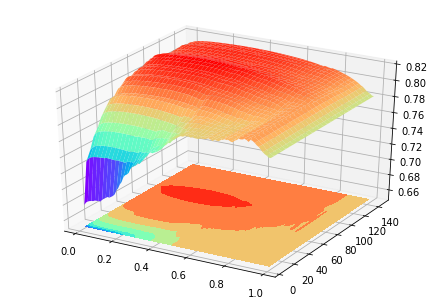

In [16]:
X, Y = np.meshgrid(thrs, n_thrs)

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_surface(X, Y, scores, cmap='rainbow')
ax.contourf(X, Y, scores, zdir='z', offset=0.65, cmap='rainbow')
ax.set_zlim(0.65, 0.82)

plt.show()

In [17]:
max_score = np.max(scores)
n_thr_idx, thr_idx = np.unravel_index(np.argmax(scores), scores.shape)

print('max_score: {}, best_thr: {}, best_n_thr: {}'.format(max_score, thrs[thr_idx], n_thrs[n_thr_idx]))

max_score: 0.8245787024497986, best_thr: 0.3, best_n_thr: 95


## test

In [31]:
net = Net().cuda()
net.load_state_dict(torch.load('bes-cp-5.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [32]:
best_thr = 0.3
best_n_thr = 95

In [38]:
test_dataset = SIIMDataset(
    data_root,
    0,
    width=SIZE, height=SIZE,
    phase='test',
    augment=null_augment,
    random_state=SEED,
    nfolds=10
)

test_loader  = DataLoader(
    test_dataset,
    # sampler     = RandomSampler(val_dataset),
    batch_size  = batch_size,
    drop_last   = False,
    num_workers = 8,
    pin_memory  = True,
    collate_fn  = null_collate
)

In [64]:
m_probs, b_probs, truths = tta(net, test_loader)

100%|██████████| 173/173 [00:19<00:00,  8.86it/s]


In [65]:
m_probs = m_probs.cuda()

m_probs[m_probs.view(m_probs.shape[0], -1).sum(-1) < best_n_thr*(SIZE/128.0)**2,...] = 0.0
preds = (m_probs>best_thr).long()

masks = preds.cpu().numpy().squeeze() * 255

In [66]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)

    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, masks)

In [78]:
# ok, export submission csv
ids = [filename.rsplit('.', 1)[0] for filename in test_dataset.filenames]

sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('bes_sub.csv', index=False)

sub_df.head(20)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1
5,1.2.276.0.7230010.3.1.4.8323329.6236.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6680.151787519...,-1
7,1.2.276.0.7230010.3.1.4.8323329.6967.151787520...,-1
8,1.2.276.0.7230010.3.1.4.8323329.6923.151787520...,-1
9,1.2.276.0.7230010.3.1.4.8323329.6744.151787519...,-1
